## Activity Tracking Project
Group 44: Abdellah Ghassel (20230384), Kyle Deverell (20217339), Liam O'Regan (20233042)


# Import Libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

# Functions

These are the primary functions used for preprocessing. These involve labelling the data, cleaning the first 

In [39]:
activity_codes = {"jumping": 0, "walking": 1}

#label data with activity codes
def labelActivityFunc(dataFiles):
    labelledData = []
    for person, activities in dataFiles.items():
        for activity, positions in activities.items():
            for position, path in positions.items():
                data = pd.read_csv(path)
                data["Activity"] = activity_codes[activity]
                labelledData.append(data)
    return labelledData

#remove first and last 5 seconds of data
#apply rolling average to smooth data
def removeFiveSecRollFunc(df, window_size):
    start = df["Time (s)"].min()
    end = df["Time (s)"].max()
    df = df[(df["Time (s)"] > start + 5) & (df["Time (s)"] < end - 5)]

    df = df.rolling(window_size).mean().dropna()
    return df

#segment data into 5 second windows
#shuffle data
def segmentFunc(data):
    samples = len(data)
    windowSize = 5
    sampleRate = 100
    windowSamples = windowSize * sampleRate
    segments = []
    for i in range(0, samples, windowSamples):
        segment = data[i:i+windowSamples]
        if len(segment) == windowSamples:
            segments.append(segment)
    np.random.shuffle(segments)
    
    return segments

#extract features from absolute acceleration of each segment
def featuresFunc(segment):
    features = []
    columnData = segment['Absolute acceleration (m/s^2)']
    
    mean = columnData.mean()
    std = columnData.std()
    minimum = columnData.min()
    maximum = columnData.max()
    skewness = columnData.skew()
    mean_squared = np.mean(columnData**2)
    kurtosis = columnData.kurtosis()
    variance = columnData.var()
    median = columnData.median()
    q1 = columnData.quantile(0.25)
    q3 = columnData.quantile(0.75)
    iqr = q3 - q1
    range = maximum - minimum
    
    features.extend([mean, std, minimum, maximum, skewness, mean_squared, kurtosis, variance, median, q1, q3, iqr, range])
    return features

#normalize data except for time and activity columns
def normalizeFunc(data):
    data_copy = data.copy()
    scaler = MinMaxScaler()
    data_copy.iloc[:, 1:-1] = scaler.fit_transform(data_copy.iloc[:, 1:-1])
    return data_copy


# Loading & Preprocessing

The raw csv files are stored in a dictionary. This makes it easy to modify which files we are including in our training.

Note: The files that were commented out were initially investigated and were either collected differently than the rest or contained significant errors. All explained in the report.

In [40]:
dataFiles = {
    "kyle": {
        "jumping": {
            #"hand": "data/jumping/kjh_data.csv",
            #"front": "data/jumping/kjf_data.csv",
            #"back": "data/jumping/kjb_data.csv",
            "newback": "data/newData/kyle_jump_back.csv",
            "newfront": "data/newData/kyle_jump_front.csv",
        },
        "walking": {
            #"hand": "data/walking/kwh_data.csv",
            #"front": "data/walking/kwf_data.csv",
            #"back": "data/walking/kwb_data.csv",
            "newback": "data/newData/kyle_walk_back.csv",
            "newfront": "data/newData/kyle_walk_front.csv",
            "newHand": "data/newData/kyleRawWalkingGUI.csv",
        },
    },
    "abdellah": {
        "jumping": {
            "backright": "data/jumping/ajbrp_data.csv",
            "frontleft": "data/jumping/ajflp_data.csv",
            "hand": "data/NewData/abdellah_jump_hand.csv",
            "pocket": "data/NewData/abdellah_jump_pocket.csv",
        },
        "walking": {
            "backright": "data/walking/awbrp_data.csv",
            "frontleft": "data/walking/awflp_data.csv",
            #"pocket": "data/NewData/abdellah_walking_pocket.csv",
        },
    },
    "liam": {
        "jumping": {
            "backleft": "data/jumping/ljlbp_data.csv",
            "backright": "data/jumping/ljbrp_data.csv",
        },
        "walking": {
            "lefthand": "data/walking/lwlh_data.csv",
            "leftpocket": "data/walking/lwlp_data.csv",
            "righthand": "data/walking/lwrh_data.csv",
            "rightpocket": "data/walking/lwrp_data.csv",
            "newHand": "data/newData/liamRawWalkingGUI.csv",
        },
    },
}


Preprocessing functions are applied below:

In [41]:
labelledData = labelActivityFunc(dataFiles)
preprocessedData = [removeFiveSecRollFunc(df, 5) for df in labelledData]
normalizedData = [normalizeFunc(df) for df in preprocessedData]

# Null Verification

Check for null accelerations, time or activity labelling

In [42]:
pd.concat(labelledData).isna().sum()

Time (s)                         0
Linear Acceleration x (m/s^2)    0
Linear Acceleration y (m/s^2)    0
Linear Acceleration z (m/s^2)    0
Absolute acceleration (m/s^2)    0
Activity                         0
dtype: int64

Check the data for duplicates

In [43]:
pd.concat(labelledData).duplicated().sum()

0

In [44]:
pd.concat(labelledData).describe()

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2),Absolute acceleration (m/s^2),Activity
count,167981.000000,167981.000000,167981.000000,167981.000000,167981.000000,167981.000000
mean,50.747097,-0.004205,-0.224195,-0.025998,9.386011,0.538734
std,33.780381,6.482606,12.039439,5.127809,11.190171,0.498499
min,-0.002278,-120.683968,-149.321104,-114.543998,0.044167,0.000000
25%,23.317325,-2.041575,-3.566690,-1.727070,3.604903,0.000000
50%,46.629565,0.129978,-0.073924,0.269133,6.502557,1.000000
75%,72.772599,2.419260,5.012756,2.210979,11.360057,1.000000
max,150.671737,114.469846,82.346385,77.136263,177.089309,1.000000


This is interesting because we have a negative time, so data cleaning must be performed.

In [45]:
pd.concat(preprocessedData).describe()

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2),Absolute acceleration (m/s^2),Activity
count,149876.000000,149876.000000,149876.000000,149876.000000,149876.000000,149876.00000
mean,51.244326,-0.000364,-0.226885,-0.030265,9.700683,0.53661
std,31.543023,5.600361,10.823087,4.017736,9.669077,0.49866
min,5.021235,-66.234362,-91.707970,-37.413340,0.317650,0.00000
25%,25.828943,-1.962463,-3.618586,-1.719133,3.976805,0.00000
50%,46.629540,0.117204,-0.056154,0.246600,7.164557,1.00000
75%,70.785830,2.294105,5.278768,2.063154,11.879967,1.00000
max,145.644026,67.678954,44.368059,39.090528,113.321620,1.00000


After preprocessing our data, we removed about 20,000 rows of data. This was the first and last five seconds of each file and applied a rolling window with a window size of 5.

# Visualize Data

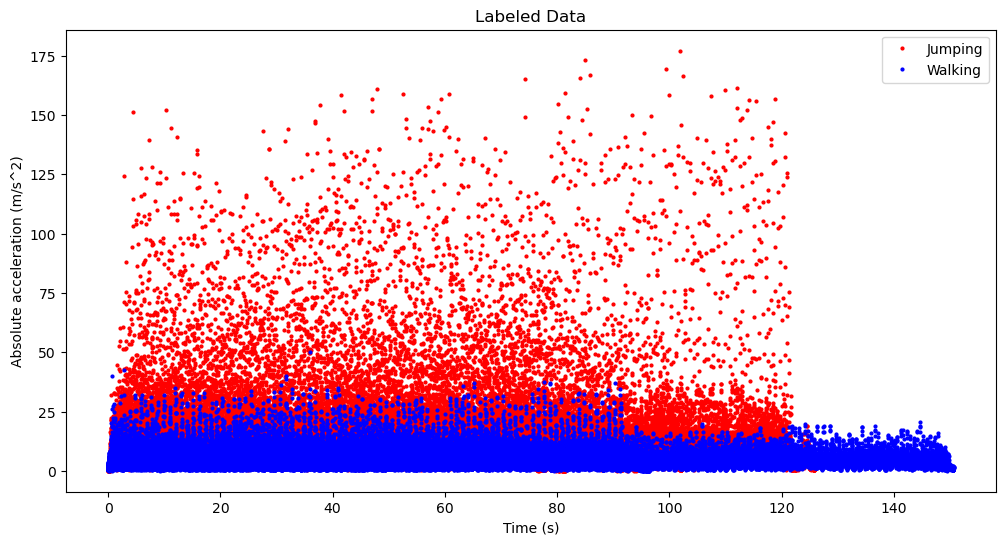

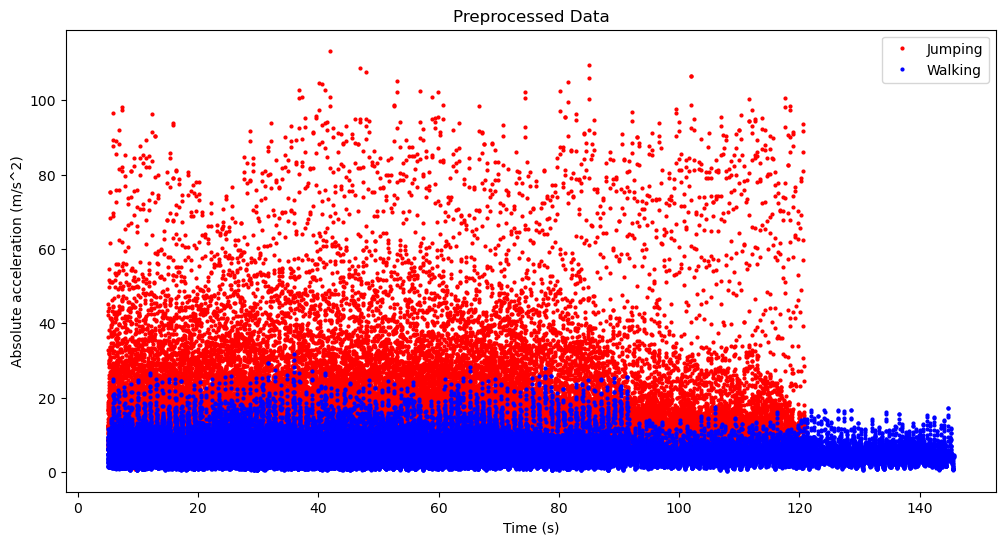

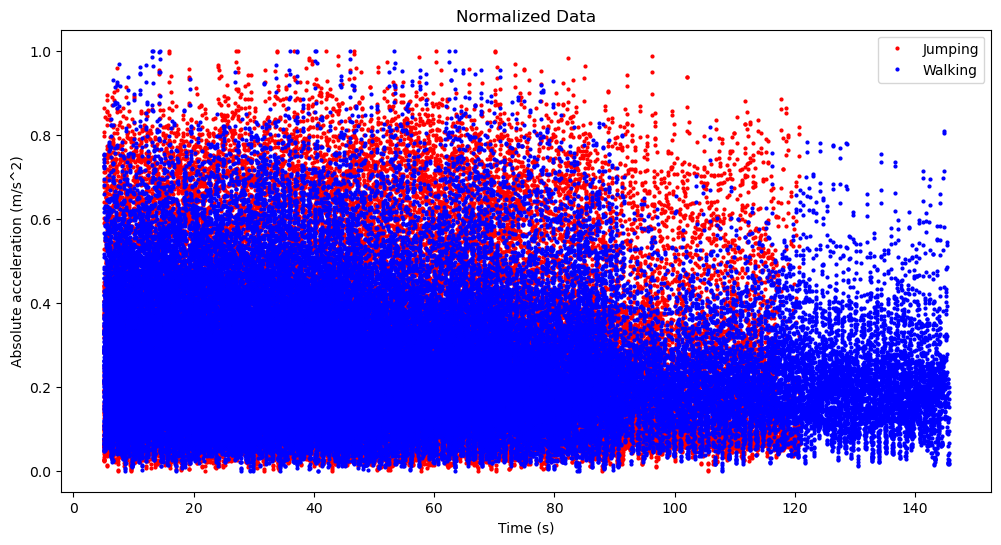

In [46]:
activity_colors = {0: 'red', 1: 'blue'}
activity_labels = {0: 'Jumping', 1: 'Walking'}

plt.rcdefaults()
style.use('seaborn-colorblind')

# Plot labelledData
labelledDataCombined = pd.concat(labelledData)
plt.figure(figsize=(12, 6))
for activity, color in activity_colors.items():
    activity_data = labelledDataCombined[labelledDataCombined['Activity'] == activity]
    plt.plot(activity_data['Time (s)'], activity_data['Absolute acceleration (m/s^2)'], 'o', markersize=2, color=color, label=activity_labels[activity])
plt.title('Labeled Data')
plt.xlabel('Time (s)')
plt.ylabel('Absolute acceleration (m/s^2)')
plt.legend()
plt.show()

# Plot preprocessedData
preprocessedDataCombined = pd.concat(preprocessedData)
plt.figure(figsize=(12, 6))
for activity, color in activity_colors.items():
    activity_data = preprocessedDataCombined[preprocessedDataCombined['Activity'] == activity]
    plt.plot(activity_data['Time (s)'], activity_data['Absolute acceleration (m/s^2)'], 'o', markersize=2, color=color, label=activity_labels[activity])
plt.title('Preprocessed Data')
plt.xlabel('Time (s)')
plt.ylabel('Absolute acceleration (m/s^2)')
plt.legend()
plt.show()

# Plot normalizedData
normalizedDataCombined = pd.concat(normalizedData)
plt.figure(figsize=(12, 6))
for activity, color in activity_colors.items():
    activity_data = normalizedDataCombined[normalizedDataCombined['Activity'] == activity]
    plt.plot(activity_data['Time (s)'], activity_data['Absolute acceleration (m/s^2)'], 'o', markersize=2, color=color, label=activity_labels[activity])
plt.title('Normalized Data')
plt.xlabel('Time (s)')
plt.ylabel('Absolute acceleration (m/s^2)')
plt.legend()
plt.show()


# Segmenting and Labelling

In [47]:
segmentedData = []
for data in normalizedData:
    segmentedData.extend(segmentFunc(data))

data = []
labels = []

for segment in segmentedData:
    data.append(featuresFunc(segment))
    label = segment.iloc[0, -1]
    labels.append(label)

In [48]:
pd.concat(segmentedData)

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2),Absolute acceleration (m/s^2),Activity
2004,20.047238,0.637944,0.257828,0.380225,0.080969,0.0
2005,20.057252,0.640854,0.213100,0.389485,0.135170,0.0
2006,20.067267,0.653607,0.172088,0.408982,0.193523,0.0
2007,20.077282,0.681881,0.133349,0.440646,0.252119,0.0
2008,20.087296,0.730521,0.095949,0.491958,0.312244,0.0
...,...,...,...,...,...,...
13003,129.189806,0.455117,0.363378,0.533894,0.093274,1.0
13004,129.199742,0.455969,0.359224,0.529947,0.089485,1.0
13005,129.209677,0.478615,0.339131,0.519009,0.078023,1.0
13006,129.219614,0.514632,0.308132,0.503313,0.068759,1.0


In [49]:
pd.DataFrame(data).shape, pd.DataFrame(labels).shape

((291, 13), (291, 1))

# Classification & Dimensionality Reduction

PCA was used for dimensionality reduction to reduce the number of components down to two.
Classification was peformed using Logistic Regression.

In [50]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42, shuffle = True)

pipe = make_pipeline(PCA(n_components=2), LogisticRegression())
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.4f}")
auc = roc_auc_score(y_test, y_pred)
print(f'AUC: {auc:.2f}')

class_report = classification_report(y_test, y_pred)

print("\nClassification Report:")
print(class_report)

Accuracy: 0.9000
Recall: 0.8889
AUC: 0.89

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.83      0.87        12
         1.0       0.89      0.94      0.92        18

    accuracy                           0.90        30
   macro avg       0.90      0.89      0.89        30
weighted avg       0.90      0.90      0.90        30



Assess the model's performance using sklearn "learning curve" function. The model's performance improves as the number of training examples increases. The training evaluation is compared against a 5-fold cross-validation. Cross validation is more thorough by training and testing the model on different subsets of data.

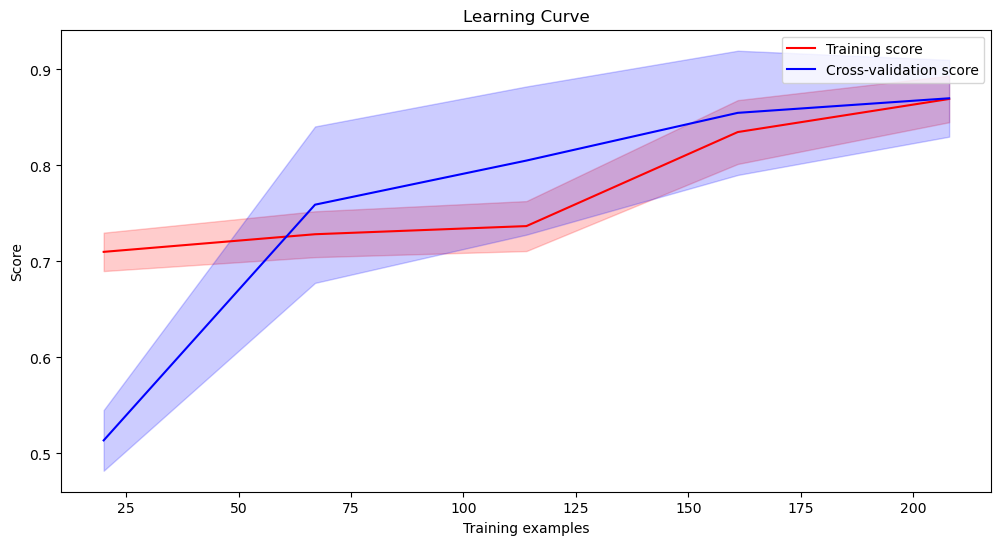

In [51]:
train_sizes, train_scores, test_scores = learning_curve(pipe, x_train, y_train, cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train_sizes, train_scores_mean, label="Training score", color="red")
ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="red")
ax.plot(train_sizes, test_scores_mean, label="Cross-validation score", color="blue")
ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="blue")
ax.set_xlabel("Training examples")
ax.set_ylabel("Score")
ax.legend(loc="best")
ax.set_title("Learning Curve")
plt.show()


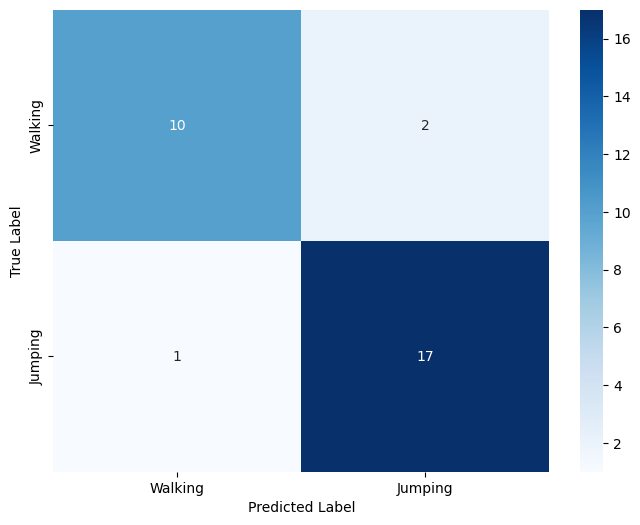

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


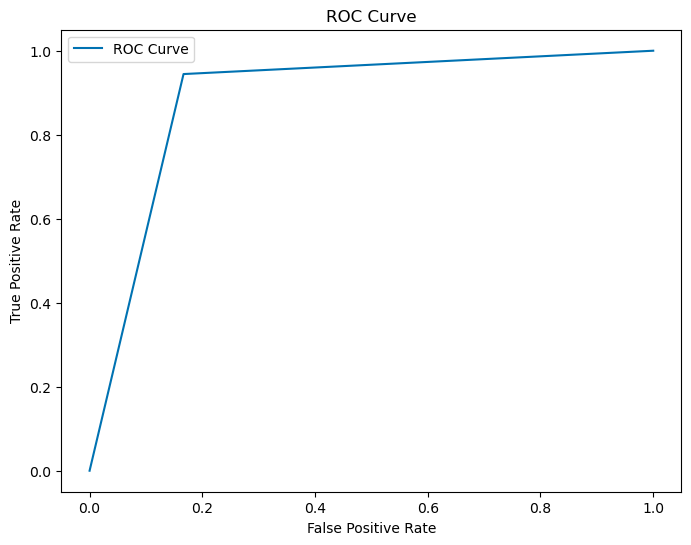

In [52]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=['Walking', 'Jumping'], yticklabels=['Walking', 'Jumping'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot ROC curve using seaborn
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
sns.lineplot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Output Model

The model was outputted as a pickle file to be used for the GUI.

In [53]:
with open("model.pkl", "wb") as f:
    pickle.dump(pipe, f)